# Тексты домашних заданий

## Homework 2.1

Исходные данные - Yandex Cup 2022 RecSys:
- Описание соревнования - https://contest.yandex.ru/yacup/contest/41618/problems/
- Данные - https://disk.yandex.ru/d/SI1aAooPn9i8TA
- Описание данных - в архиве likes_data.zip три файла:
  - train - обучающий набор данных. Каждая строка - последовательность id треков, которые лайкнул один пользователь. Гарантируется, что лайки даны в той последовательности, в которой их ставил пользователь.
  - test - набор тестовых данных. Имеет точно такой же формат, но в каждой строке не хватает последнего лайка, который надо предсказать.
  - track_artists.csv - информация о исполнителях треков. Гарантируется, что у каждого трека есть ровно один исполнитель. Для треков, у которых фактически несколько исполнителей, мы оставили того, который считается основным исполнителем трека.
- Описание сабмита - в качестве решения необходимо отправить файл, в котором для каждого пользователя из test в отдельной строке будет не более 100 треков, разделенных пробелом. Гарантируется, что у каждого пользователя будет только 1 лайк в тесте
- Метрика - MRR@100

Промежуточная задача - преобразовать данные в pandas.DataFrame вида {user, item, order}, где order - порядковый номер с конца (0 - самый "свежий" лайк, чем больше order, тем позже был поставлен лайк)

**Итоговая задача** - построить схему валидации для данного соревнования с учетом особенностей сорвенования
- Между `train` и `test` не должно быть общих пользователей
- Количество фолдов задается через параметр класса `n_folds`
- В `test` должно быть не более `p` последних треков (параметр класса `p`)

## Homework 2.2

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)

### MRR
Исходные данные - результат `generate_subsample`

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

# Create data

In [ ]:
import pandas as pd
from tqdm import tqdm

In [ ]:
df = pd.concat(
    [
        pd.read_csv('../data/hw_2/validation/train', sep=',', header=None),
        pd.read_csv('../data/hw_2/validation/test', sep=',', header=None)
    ],
    ignore_index=False
)

user, item, order = list(), list(), list()

for idx in tqdm(range(df.shape[0])):
    curr_items = [int(item) for item in df[0].iloc[idx].split()]
    user.extend([idx for _ in curr_items])
    item.extend(curr_items)
    order.extend([like for like in reversed(range(len(curr_items)))])

df = pd.DataFrame(
    {
        'user': user,
        'item': item,
        'order': order
    }
)

df.to_csv('../data/hw_2/validation/data_for_task.csv', index=False)

# Validation

In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy as np
import pandas as pd

from service.utils.validation.user_kfold_pout import UsersKFoldPOut

In [3]:
df = pd.read_csv('../data/hw_2/validation/data_for_task.csv')

In [4]:
P = 15
N_FOLD = 3

In [5]:
cv = UsersKFoldPOut(n_folds=N_FOLD, p=P)

for i, (train_mask, test_mask) in enumerate(cv.split(df)):
    train = df[train_mask]
    test = df[test_mask]
    users_train_unique = train['user'].unique()
    users_test_unique = test['user'].unique()
    test_users_not_in_train = np.setdiff1d(users_test_unique, users_train_unique).shape[0]

    assert test_users_not_in_train == users_test_unique.shape[0], "В train и test есть общие юзеры!"
    assert test[test['order'] > (P - 1)].shape[0] == 0, f"В test есть действия позднее {P}-го"
    assert test['order'].unique().shape[0] == P, f"В тесте более {P} дейстий"

    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 62769950, Test: 5342919
Fold#1 | Train: 62749697, Test: 5344940
Fold#2 | Train: 62857621, Test: 5342556


**Проанализируем заключительный Fold**

In [6]:
train

,user,item,order
54,1,174197,9
55,1,335779,8
56,1,141676,7
57,1,119856,6
58,1,376664,5
...,...,...,...
94188373,1160082,278375,4
94188374,1160082,399255,3
94188375,1160082,7045,2
94188376,1160082,287708,1


In [7]:
test

,user,item,order
39,0,170753,14
40,0,432424,13
41,0,330581,12
42,0,63471,11
43,0,424658,10
...,...,...,...
94188629,1160083,80233,4
94188630,1160083,369632,3
94188631,1160083,46592,2
94188632,1160083,408275,1


In [8]:
users_train = train['user'].unique()
users_test = test['user'].unique()
np.setdiff1d(users_test, users_train).shape[0] == users_test.shape[0]

True

In [9]:
test[test['order'] > P - 1].shape[0] == 0

True

# Metrics

In [10]:
from time import monotonic

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import numba as nb
from tqdm import tqdm

## Mean Reciptrocal Rank

In [11]:
df = pd.read_csv('../data/kion_train/interactions.csv')
df.rename(
    columns={
        'user_id': 'user',
        'item_id': 'item'
    },
    inplace=True
)
del df['last_watch_dt'], df['total_dur'], df['watched_pct']
df

,user,item
0,176549,9506
1,699317,1659
2,656683,7107
3,864613,7638
4,964868,9506
...,...,...
5476246,648596,12225
5476247,546862,9673
5476248,697262,15297
5476249,384202,16197


In [12]:
def generate_subsample(df, users_count, top_k):
    users = np.random.choice(df['user'].unique(), users_count, replace=False)
    df_return = df[df['user'].isin(users)].reset_index(drop=True)

    recs = np.random.choice(df_return['item'], size=(users_count, top_k))
    return df_return, users, recs

In [18]:
def mrr_naive(target, users, recs, k):
    mrr = []
    for idx_user, user in enumerate(users):
        sum_invers_rank = 0
        user_target = target[target[:, 0] == user][:, 1]
        for idx_rec, rec in enumerate(recs[idx_user], start=1):
            if rec in user_target:
                sum_invers_rank = 1 / idx_rec
                break
        mrr.append(sum_invers_rank)
    return round(sum(mrr) / len(users), 6)


@nb.njit(cache=True, parallel=True, nopython=False)
def mrr_numba(target, users, recs, k):
    mrr = np.zeros(len(users))
    for idx_user in nb.prange(len(users)):
        user = users[idx_user]
        sum_invers_rank = 0
        user_target = target[target[:, 0] == user][:, 1]
        for idx_rec in nb.prange(len(recs[idx_user])):
            if recs[idx_user][idx_rec] in user_target:
                sum_invers_rank += 1 / (idx_rec + 1)
                break
        mrr[idx_user] = sum_invers_rank
    return round(mrr.mean(), 6)


def mrr_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
            'user': np.repeat(users, k),
            'item': recs.ravel()
    })
    df_recs['rank'] = df_recs.groupby('user').cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=['user', 'item'], right_on=['user', 'item'])
    tp_k = f'TP@{k}'
    df_recs[tp_k] = df_recs['rank'] < (k + 1)
    if df_recs[df_recs[tp_k] == True].shape[0] > 0:
        p = sum(1 / df_recs[df_recs[tp_k] == True].groupby('user')['rank'].agg('min')) / len(users)
    else:
        p = 0
    return round(p, 6)

/home/mlandrey/PycharmProjects/ITMO/RecSys_MTC/RecoServiceTemplate/.venv/lib/python3.8/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [14]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
all_values = dict()
for user_count in users_count:
    for k in top_k:
        all_values[f'{user_count}_{k}'] = generate_subsample(df, user_count, k)

In [19]:
algorithm, time, user_count_values, top_k_values = [], [], [], []
for user_count in tqdm(users_count):
    for k in top_k:
        curr_df, curr_users, curr_recs = all_values[f'{user_count}_{k}']

        strat_time = monotonic()
        res_naive = mrr_naive(curr_df.values, curr_users, curr_recs, k)
        time.append(monotonic() - strat_time)
        algorithm.append('naive')
        user_count_values.append(user_count)
        top_k_values.append(k)

        strat_time = monotonic()
        res_numba = mrr_numba(curr_df.values, curr_users, curr_recs, k)
        time.append(monotonic() - strat_time)
        algorithm.append('numba')
        user_count_values.append(user_count)
        top_k_values.append(k)

        strat_time = monotonic()
        res_pandas = mrr_pandas(curr_df, curr_users, curr_recs, k)
        time.append(monotonic() - strat_time)
        algorithm.append('pandas')
        user_count_values.append(user_count)
        top_k_values.append(k)

        assert res_naive == res_numba, "Значения MRR naive и numba не совпадают!"
        assert res_naive == res_pandas, "Значения MRR naive и pandas не совпадают!"
        assert res_pandas == res_numba, "Значения MRR pandas и numba не совпадают!"

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:27<00:00, 111.96s/it]


In [23]:
df_result = pd.DataFrame(
    {
        "algorithm": algorithm,
        "time": time,
        "user_count": user_count_values,
        "top_k": top_k_values
    }
)

df_result

,algorithm,time,user_count,top_k
0,naive,0.002646,100,10
1,numba,1.514801,100,10
2,pandas,0.004732,100,10
3,naive,0.008836,100,50
4,numba,0.000078,100,50
5,pandas,0.004116,100,50
6,naive,0.012074,100,100
7,numba,0.000080,100,100
8,pandas,0.004277,100,100
9,naive,0.036420,1000,10


In [24]:
df_result.to_csv('../data/hw_2/metrics/results_mrr.csv', index=False)

In [25]:
def plot_result(ax, K: int, res_naive: pd.DataFrame, res_numba: pd.DataFrame, res_pandas: pd.DataFrame):
    ax.plot(res_naive['user_count'], res_naive['time'], label='naive')
    ax.plot(res_numba['user_count'], res_numba['time'], label='numba')
    ax.plot(res_pandas['user_count'], res_pandas['time'], label='pandas')
    ax.legend()
    ax.grid(True)
    ax.set_title(f"K = {K}")
    ax.set_xlabel(f"user_count")
    ax.set_ylabel(f"time")

In [26]:
res_naive = df_result[df_result['algorithm'] == 'naive']
res_numba = df_result[df_result['algorithm'] == 'numba']
res_pandas = df_result[df_result['algorithm'] == 'pandas']

In [27]:
res_naive

,algorithm,time,user_count,top_k
0,naive,0.002646,100,10
3,naive,0.008836,100,50
6,naive,0.012074,100,100
9,naive,0.036420,1000,10
12,naive,0.064838,1000,50
15,naive,0.092772,1000,100
18,naive,1.263562,10000,10
21,naive,1.646041,10000,50
24,naive,1.979929,10000,100
27,naive,123.077702,100000,10


In [28]:
res_numba

,algorithm,time,user_count,top_k
1,numba,1.514801,100,10
4,numba,0.000078,100,50
7,numba,0.000080,100,100
10,numba,0.003454,1000,10
13,numba,0.002869,1000,50
16,numba,0.002635,1000,100
19,numba,0.233376,10000,10
22,numba,0.221348,10000,50
25,numba,0.216455,10000,100
28,numba,21.107522,100000,10


первое значение времени, не совсем является объективным, т.к. numba необходимо **прогреть**

In [30]:
res_pandas

,algorithm,time,user_count,top_k
2,pandas,0.004732,100,10
5,pandas,0.004116,100,50
8,pandas,0.004277,100,100
11,pandas,0.006680,1000,10
14,pandas,0.009150,1000,50
17,pandas,0.013737,1000,100
20,pandas,0.022437,10000,10
23,pandas,0.056730,10000,50
26,pandas,0.130295,10000,100
29,pandas,0.235035,100000,10


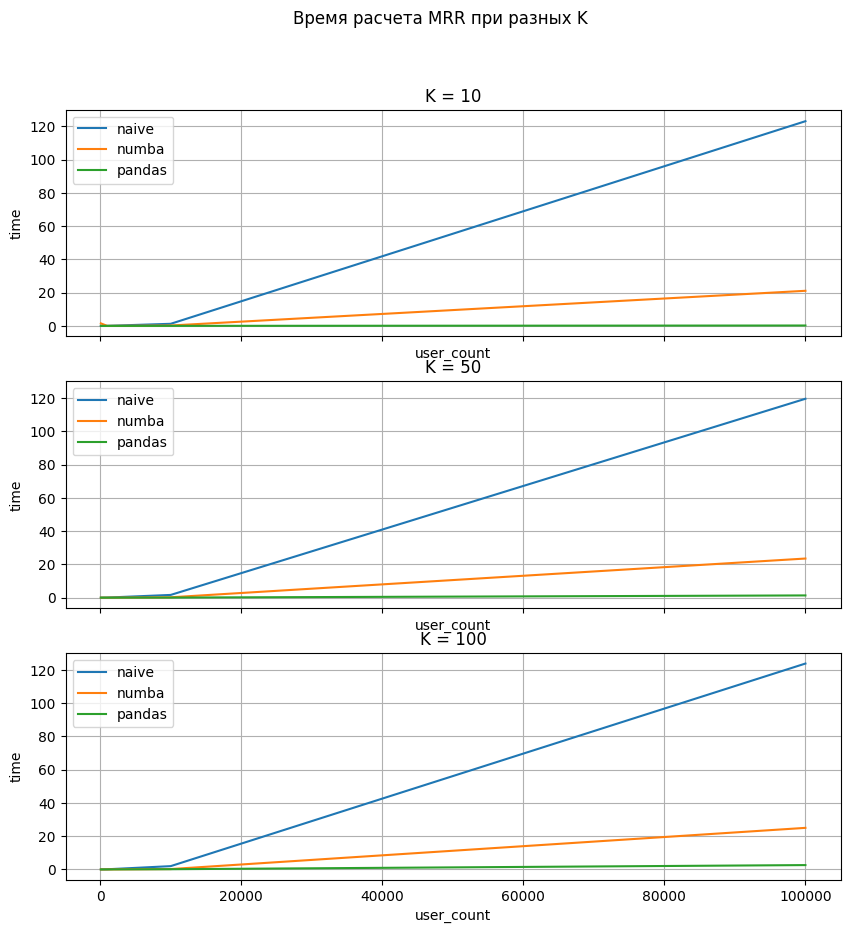

In [32]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 10))
fig.suptitle('Время расчета MRR при разных K')

for idx, k in enumerate(top_k):
    plot_result(
        axs[idx], k, res_naive[res_naive['top_k'] == k], res_numba[res_numba['top_k'] == k],
        res_pandas[res_pandas['top_k'] == k]
    )

Из графиков видно, что для разных K **тенденция** разницы во времени для разных реализациий **сохраняется**
Как и предполагалась самая быстрая реализация для **pandas

## PFound

### Скачаем и разархивируем датасет

In [2]:
!gdown https://drive.google.com/file/d/1z2BD7U-tCI3EGlPFm4bIRWg4w8bYVe9g/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1z2BD7U-tCI3EGlPFm4bIRWg4w8bYVe9g
To: /content/yandex_cup_analytics_A.zip
100% 75.4k/75.4k [00:00<00:00, 58.1MB/s]


In [3]:
!unzip yandex_cup_analytics_A.zip

%mkdir hidden_task
!unzip hidden_task.zip -d hidden_task

!unzip open_task.zip

Archive:  yandex_cup_analytics_A.zip
  inflating: hidden_task.zip         
  inflating: open_task.zip           
Archive:  hidden_task.zip
  inflating: hidden_task/hostid_url.tsv  
  inflating: hidden_task/qid_query.tsv  
  inflating: hidden_task/qid_url_rating.tsv  
Archive:  open_task.zip
   creating: open_task/
  inflating: open_task/qid_query.tsv  
  inflating: open_task/hostid_url.tsv  
  inflating: open_task/qid_url_rating.tsv  


### Посмотрим на датасет

In [4]:
import pandas as pd
import numpy as np

import time

In [8]:
# считываем данные
qid_query = pd.read_csv("hidden_task/qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("hidden_task/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("hidden_task/hostid_url.tsv", sep="\t", names=["hostid", "url"])

# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")

pd.merge(qid_query, qid_url_rating_hostid, on='qid').sort_values(by=['qid', 'rating'], ascending=False)

,qid,query,url,rating,hostid
561,692308,бесплатный просмотр камеди клаб,http://www.rucomedy.com/,0.61,1035
549,692308,бесплатный просмотр камеди клаб,http://tnt-online.ru/smotret-comedy-club.html,0.41,551
569,692308,бесплатный просмотр камеди клаб,http://www.youtube.com/watch?v=LfR1rYXKaQM,0.41,1155
537,692308,бесплатный просмотр камеди клаб,http://all-hit.tv/1416-kamedi-klab-smotret-onl...,0.14,33
538,692308,бесплатный просмотр камеди клаб,http://bigcinema.tv/tvshows/kamedi-klab-serial...,0.14,70
...,...,...,...,...,...
313,5308,home нет доменов,http://www.domain.com/,0.00,767
315,5308,home нет доменов,http://www.irm.ru/content/domen.html,0.00,866
317,5308,home нет доменов,http://www.nic.ru/?ipartner=182&adv_id=wkmain,0.00,960
319,5308,home нет доменов,http://www.sites.google.com/,0.00,1050


### Циклический pFound

#### pFound от Яндекса

In [9]:
def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def naive_pfound(group):
    """Реализация pFound с сайта Yandex cup"""
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
    return pfound

#### Немного ускоренный циклический pFound
Немного ускорил для нормального сравнения. В официальной версии от Яндекса plook считался очень долго для большого k из-за постоянной рекурсии. Его можно ускорить с помощью динамического программирования

In [13]:
def plook_dinamic(rels):
    plook_mult = np.empty(len(rels))
    plook_mult[0] = 1
    for i in range(1, len(plook_mult)):
        plook_mult[i] = plook_mult[i - 1] * (1 - rels[i - 1]) * (1 - 0.15)
    return plook_mult


def pfound_cicle_speed(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    plook_mult = plook_dinamic(top10.values)
    for ind, val in enumerate(top10):
        pfound += val*plook_mult[ind]
    return pfound

#### Расчет plook с помощью numba.
Оставил, чтобы просто был.

In [14]:
from numba import jit

@jit(nopython=True)
def calc_plook(df):
    """
      Принимает на вход plook_multi.to_numpy(). Возвращает посчитанную матрицу plook.
    """
    res = np.empty(len(df))
    res[0] = df[0]
    for i in range(1, res.shape[0]):
        res[i] = res[i-1] * df[i]
    return res

### pFound с pandas

#### pfound только с помощью pandas без numba, но с apply

In [15]:
def pfound_pandas_with_apply(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом

    # Берем вторые множители вместе с (1-pBreak), сдвигаем вниз на 1 строку, чтоб в соседней строке лежали предыдущие строки, и заполняем первую строку единицей
    plook_mult = ((1 - top10.shift(1)) * (1 - 0.15)).fillna(1) # Вторые множители plook
    plook = plook_mult.cumprod() # Накопленное произведение - в каждой строчке появляется произведение предыдущих строк

    pfound = (top10 * plook).sum()  # Умножаем наши рейтинги на plook и суммируем по формуле

    return pfound

#### pFound с pandas без apply
Та самая функция из домашки. Возвращает средний pFound

In [16]:
def pfound_pandas(df, k: int = 10):
    """
      Функция принимает на вход DataFrame с колонками qid, hostid, rating.
      Функция возвращает mean pFound среди всех qid.
    """

    max_by_host = df.groupby(["qid", "hostid"])["rating"].max().reset_index() # максимальный рейтинг хоста в каждом qid
    # берем топ 10 урлов с наивысшим рейтингом для каждого qid
    top10 = max_by_host.sort_values(['qid', 'rating'], ascending=False).groupby('qid').head(k)

    top10['rank_qid'] = top10.groupby('qid').cumcount() # В каждом qid пронумеруем hostid

    # Берем вторые множители вместе с (1-pBreak), сдвигаем вниз на 1 строку, чтоб в соседней строке лежали предыдущие строки,
    # и заполняем первую строку единицей, на i-х строках i-1-е множители
    top10['plook_mult'] = (1 - top10['rating'].shift(1)) * (1 - 0.15)
    top10.loc[top10['rank_qid'] == 0, 'plook_mult'] = 1  # На нулевых местах должны быть единицы
    top10['plook'] = top10.groupby('qid')['plook_mult'].cumprod()  # Получаем plook на i-х позициях
    top10['pfound_item'] = top10['rating'] * top10['plook']  # Получаем слагаемые pfound

    mean_pfound = top10.groupby('qid')['pfound_item'].sum().mean()

    return mean_pfound

### Сравним *циклический pFound* и *pFound с pandas*

#### Сравним на текущем датасете

In [23]:
def pandas_apply_pfound(df, func_pfound):
    """Реализация pFound с apply"""
    pfound_res = df.groupby('qid').apply(func_pfound)
    return pfound_res.mean()

Циклический pFound с рекурсиями

In [29]:
start_time = time.time()
mean_pfound = pandas_apply_pfound(qid_url_rating_hostid, naive_pfound)  # Используем наивный алгоритм
print(time.time() - start_time)

print('mean pFound =', mean_pfound)

0.027570247650146484
mean pFound = 0.5822199638393889


Циклический pFound с динамическим программированием

In [32]:
start_time = time.time()
mean_pfound_dinamic = pandas_apply_pfound(qid_url_rating_hostid, pfound_cicle_speed)  # Используем наивный алгоритм с динамическим прогр
print(time.time() - start_time)

print('mean pFound =', mean_pfound_dinamic)

0.022918224334716797
mean pFound = 0.5822199638393889


pFound с pandas и с apply

In [33]:
start_time = time.time()
mean_pfound_pandas_apply = pandas_apply_pfound(qid_url_rating_hostid, pfound_pandas_with_apply)  # Используем pandas с apply
print(time.time() - start_time)

print('mean pFound =', mean_pfound_pandas_apply)

0.0413355827331543
mean pFound = 0.5822199638393889


pFound с pandas, но без apply

In [37]:
start_time = time.time()
mean_pfound_pandas = pfound_pandas(qid_url_rating_hostid)  # Вычисляем средний pFound
print(time.time() - start_time)

print('mean pFound =', mean_pfound_pandas)

0.01832413673400879
mean pFound = 0.5822199638393889


Проверим, есть ли различия в посчитанных метриках

In [38]:
diff_index = ['original', 'dinamic', 'pandas_apply', 'pandas_no_apply']
diff_values = [mean_pfound, mean_pfound_dinamic, mean_pfound_pandas_apply, mean_pfound_pandas]
diff = pd.DataFrame(diff_values, index=diff_index, columns=['pFound'])

diff

,pFound
original,0.58222
dinamic,0.58222
pandas_apply,0.58222
pandas_no_apply,0.58222


#### Сравним на увеличенном датасете
Датасет из 800к строк

##### Сделаем увеличенный датасет

In [39]:
qid_url_rating_hostid_big = qid_url_rating_hostid
temp_df = qid_url_rating_hostid
qid_url_rating_hostid_big

,qid,url,rating,hostid
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,http://802351.info/5964-v-avstralii.html,0.00,13
3,402111,http://auscommunity.com/blog/jobs/,0.00,53
4,402111,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53
...,...,...,...,...
798,99543,http://www.youtube.com/watch?v=QDcomRWogFE,0.14,1155
799,99543,http://www.youtube.com/watch?v=Y3n47xZb0b4,0.14,1155
800,99543,http://www.yuga.ru/articles/culture?id=3378,0.00,1156
801,99543,http://www.zexe.de/modules.php?name=Pages&pa=s...,0.14,1160


In [40]:
# Увеличим датасет примерно в 1000 раз, прибавив к каждому qid единицу
for _ in range(1000):
    temp_df['qid'] = temp_df['qid'] + 1
    qid_url_rating_hostid_big = pd.concat((qid_url_rating_hostid_big, temp_df))
temp_df = None # освобождаем переменную

In [41]:
qid_url_rating_hostid_big

,qid,url,rating,hostid
0,402112,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402112,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402112,http://802351.info/5964-v-avstralii.html,0.00,13
3,402112,http://auscommunity.com/blog/jobs/,0.00,53
4,402112,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53
...,...,...,...,...
798,100543,http://www.youtube.com/watch?v=QDcomRWogFE,0.14,1155
799,100543,http://www.youtube.com/watch?v=Y3n47xZb0b4,0.14,1155
800,100543,http://www.yuga.ru/articles/culture?id=3378,0.00,1156
801,100543,http://www.zexe.de/modules.php?name=Pages&pa=s...,0.14,1160


##### Сравним pFound

In [42]:
diff_pfound = pd.DataFrame()

Циклический pFound с рекурсиями

In [45]:
start_time = time.time()
mean_pfound_big = pandas_apply_pfound(qid_url_rating_hostid_big, naive_pfound)  # Используем наивный алгоритм
diff_times = time.time() - start_time
print(diff_times)

diff_pfound.loc['pfound_original', 'time'] = diff_times

16.929142713546753


Циклический pFound с динамическим программированием

In [46]:
start_time = time.time()
mean_pfound_dinamic_big = pandas_apply_pfound(qid_url_rating_hostid_big, pfound_cicle_speed)  # Используем наивный алгоритм с динамическим прогр
diff_times = time.time() - start_time
print(diff_times)

diff_pfound.loc['pfound_dinamic', 'time'] = diff_times

15.62254786491394


pFound с pandas и с apply

In [47]:
start_time = time.time()
mean_pfound_pandas_apply_big = pandas_apply_pfound(qid_url_rating_hostid_big, pfound_pandas_with_apply)  # Используем pandas с apply
diff_times = time.time() - start_time
print(diff_times)

diff_pfound.loc['pfound_pandas_apply', 'time'] = diff_times

32.24057197570801


pFound с pandas, но без apply

In [53]:
start_time = time.time()
mean_pfound_pandas_big = pfound_pandas(qid_url_rating_hostid)  # Вычисляем средний pFound
diff_times = time.time() - start_time
print(diff_times)

diff_pfound.loc['pfound_pandas_no_apply', 'time'] = diff_times

0.0169525146484375


#### Результаты сравнения
Сравнили четыре варианта функций подсчета метрик pFound на данных в 800к строк.<br>
Как и ожидалось, самым быстрым оказался **pFound с pandas и без apply**. Результаты сравнения ниже

In [54]:
diff_pfound


,time
pfound_original,16.929143
pfound_dinamic,15.622548
pfound_pandas_apply,32.240572
pfound_pandas_no_apply,0.016953
